<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/main/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [1]:
!gdown --id 1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm
To: /content/traffic-sign-yolo.zip
100% 261M/261M [00:01<00:00, 179MB/s]


In [2]:
!unzip "/content/traffic-sign-yolo.zip" -d "/content/"

Archive:  /content/traffic-sign-yolo.zip
replace /content/traffic-sign-yolo/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install nengo
!pip install nengo-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import skimage

### Load Data

In [2]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
MINIBATCH_SIZE = 32
N_STEPS = 1

In [3]:
dir_path = '/content/'

In [4]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Explanatory Analysis

In [5]:
np.array(image_list).shape

(741, 240, 240, 3)

In [6]:
image_list = np.array(image_list, dtype=np.float32) /255

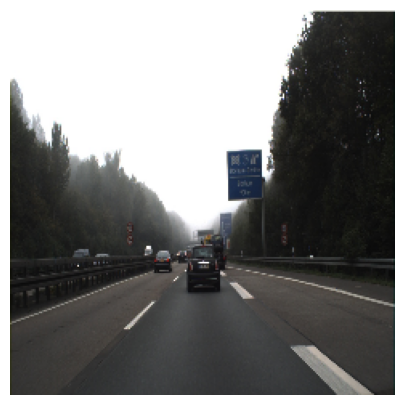

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(image_list[8])
plt.axis("off")
plt.show()

### Data Preprocessing

In [9]:
noise_data = skimage.util.random_noise(image_list, mode="gaussian")

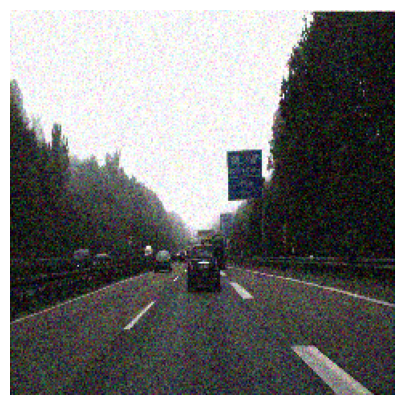

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(noise_data[8])
plt.axis("off")
plt.show()

In [11]:
train_data = np.reshape(image_list, (len(image_list), -1))
test_data = np.reshape(noise_data, (len(noise_data), -1))

In [12]:
del noise_data
del image_list

In [13]:
train_data.shape

(741, 172800)

In [14]:
train_data.shape

(741, 172800)

In [15]:
train_data = train_data[:, None, :]

In [16]:
train_data.shape

(741, 1, 172800)

In [17]:
test_data = np.tile(test_data[:, None, :], (1, N_STEPS, 1))

In [18]:
test_data.shape

(741, 1, 172800)

In [19]:
train_data

array([[[0.84705883, 0.84705883, 0.8117647 , ..., 0.03137255,
         0.05490196, 0.05490196]],

       [[1.        , 1.        , 1.        , ..., 0.14509805,
         0.27058825, 0.27058825]],

       [[1.        , 1.        , 0.99215686, ..., 0.15686275,
         0.24705882, 0.23137255]],

       ...,

       [[1.        , 1.        , 1.        , ..., 0.05098039,
         0.09803922, 0.09019608]],

       [[0.9607843 , 0.9882353 , 0.9882353 , ..., 0.36862746,
         0.47058824, 0.4509804 ]],

       [[0.9882353 , 0.9882353 , 0.9411765 , ..., 0.30588236,
         0.37254903, 0.34509805]]], dtype=float32)

In [20]:
test_data

array([[[0.62138264, 0.80949011, 0.74644049, ..., 0.        ,
         0.        , 0.10694655]],

       [[0.89712105, 1.        , 1.        , ..., 0.20360556,
         0.31571016, 0.45256973]],

       [[1.        , 1.        , 1.        , ..., 0.        ,
         0.26123271, 0.16759909]],

       ...,

       [[1.        , 0.93761935, 0.85584902, ..., 0.08966127,
         0.26897677, 0.        ]],

       [[0.95149478, 1.        , 1.        , ..., 0.26992632,
         0.24525722, 0.36618099]],

       [[0.98192672, 1.        , 1.        , ..., 0.33669529,
         0.49126998, 0.40289239]]])

### Autoencoder Network

In [21]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear()
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 256
    dim_center = 128

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_center, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    layer3 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer2.neurons, layer3.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer3.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")

In [22]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.predict(np.ones((MINIBATCH_SIZE, 1, n_in)));

Build finished in 0:00:03                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:03                                               
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


1/1 [==============================] - 2s 2s/step


### Train Model

In [23]:
for net_ens in auto_net.all_ensembles:
  net_ens.gain = nengo.dists.Choice([1])
  net_ens.bias = nengo.dists.Choice([0])

In [24]:
for conn in auto_net.all_connections:
  conn.synapse = None

In [25]:
with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.compile(optimizer = tf.optimizers.Adam(1e-4),
              loss = {p_c: tf.losses.mse,
                      p_c_filt: None}
             )
  sim.fit(train_data, train_data, epochs = 1000)
  sim.freeze_params(auto_net)

|################     Building network (25%)                     | ETA: 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f23d716b040> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f23d7169cc0> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f23d7169a80> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


|#####################Building network (41%)                     | ETA: 0:00:01

/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f23d7169840> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


Build finished in 0:00:02                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (741) is not evenly divisible by Simulator.minibatch_size (32); input data will be truncated.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1736: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


Epoch 1/1000
23/23 [==============================] - 9s 62ms/step - loss: 0.2129 - probe_loss: 0.2129
Epoch 2/1000
23/23 [==============================] - 1s 58ms/step - loss: 0.1695 - probe_loss: 0.1695
Epoch 3/1000
23/23 [==============================] - 1s 59ms/step - loss: 0.1495 - probe_loss: 0.1495
Epoch 4/1000
23/23 [==============================] - 1s 60ms/step - loss: 0.1258 - probe_loss: 0.1258
Epoch 5/1000
23/23 [==============================] - 1s 58ms/step - loss: 0.1100 - probe_loss: 0.1100
Epoch 6/1000
23/23 [==============================] - 1s 58ms/step - loss: 0.1009 - probe_loss: 0.1009
Epoch 7/1000
23/23 [==============================] - 1s 65ms/step - loss: 0.0933 - probe_loss: 0.0933
Epoch 8/1000
23/23 [==============================] - 1s 62ms/step - loss: 0.0856 - probe_loss: 0.0856
Epoch 9/1000
23/23 [==============================] - 1s 64ms/step - loss: 0.0794 - probe_loss: 0.0794
Epoch 10/1000
23/23 [==============================] - 1s 61ms/step - los

In [26]:
# with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim2:
#     sim2.load_params("./my_saved_params")